In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\utilisateur\Desktop\booking.csv", encoding = 'UTF8', na_values=['None'], sep=',', decimal=',')

In [3]:
df.head(100)

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Loshouarn,France,1,2018-06-28,Le confort comme à la maison !,J'ai énormément apprécié l'accueil et je me su...,NaN,10.0,Hôtel,Paris,8.1
1,Isabelle,France,0,2020-05-22,Calme et confortable.,"Très bon accueil, Hatim le réceptionniste est ...",NaN,8.0,Hôtel,Paris,8.1
2,Eva,Italie,0,2020-05-20,Accueil chaleureux,- Personnel irréprochable : surtout l’homme et...,- le rapport qualité prix pour la chambre supé...,8.0,Hôtel,Paris,8.1
3,François,France,0,2020-05-19,Très correct,"Merci a Hatim pour l'accueil, très appréciable...",NaN,8.0,Hôtel,Paris,8.1
4,Fabienne,France,0,2020-05-17,Très bien,"L’accueil , la situation de l’établissement",La fenêtre qui ne fermait pas très bien,8.0,Hôtel,Paris,8.1
...,...,...,...,...,...,...,...,...,...,...,...
95,Gwashton,France,0,2019-03-09,Exceptionnel,"mais tout le reste, propreté, service, literie...",Le petit-déjeuner est peut être cher pour ce q...,9.6,Hôtel,Paris,8.1
96,Jocelyne,France,0,2019-03-08,bien,Le personnel agréable,NaN,9.2,Hôtel,Paris,8.1
97,Estelle,France,0,2019-03-01,Fabuleux,Très bien,NaN,9.2,Hôtel,Paris,8.1
98,Carine202,Suisse,0,2019-02-24,Bonne expérience,Literie confortable. Petit quartier très sympa...,Chambre assez petit malgré un surclassement...,7.9,Hôtel,Paris,8.1


In [4]:
df.isnull().values.any()

True

In [5]:
df.isnull().sum()

nom                     0
pays                    0
favorite                0
date                    0
titre                   0
bons_points             0
mauvais_points        219
note                    0
type_etablissement      0
lieu                    0
note_etablissement      0
dtype: int64

In [6]:
df.dtypes

nom                    object
pays                   object
favorite                int64
date                   object
titre                  object
bons_points            object
mauvais_points         object
note                  float64
type_etablissement     object
lieu                   object
note_etablissement    float64
dtype: object

In [7]:
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Loshouarn,France,1,2018-06-28,Le confort comme à la maison !,J'ai énormément apprécié l'accueil et je me su...,NaN,10.0,Hôtel,Paris,8.1
1,Isabelle,France,0,2020-05-22,Calme et confortable.,"Très bon accueil, Hatim le réceptionniste est ...",NaN,8.0,Hôtel,Paris,8.1
2,Eva,Italie,0,2020-05-20,Accueil chaleureux,- Personnel irréprochable : surtout l’homme et...,- le rapport qualité prix pour la chambre supé...,8.0,Hôtel,Paris,8.1
3,François,France,0,2020-05-19,Très correct,"Merci a Hatim pour l'accueil, très appréciable...",NaN,8.0,Hôtel,Paris,8.1
4,Fabienne,France,0,2020-05-17,Très bien,"L’accueil , la situation de l’établissement",La fenêtre qui ne fermait pas très bien,8.0,Hôtel,Paris,8.1


In [8]:
df.shape

(389, 11)

In [9]:
#df.dropna(inplace = True)

In [10]:
#df.shape

In [11]:
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,389,389,389.000000,389,389,389,170,389.000000,389,389,3.890000e+02
unique,241,24,NaN,293,118,239,158,NaN,1,1,NaN
top,Anonyme,France,NaN,2019-02-24,Bien,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,31,323,NaN,4,71,146,10,NaN,389,389,NaN
mean,NaN,NaN,0.066838,NaN,NaN,NaN,NaN,8.278920,NaN,NaN,8.100000e+00
std,NaN,NaN,0.250063,NaN,NaN,NaN,NaN,1.331989,NaN,NaN,5.513798e-14
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2.900000,NaN,NaN,8.100000e+00
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,7.500000,NaN,NaN,8.100000e+00
50%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,8.300000,NaN,NaN,8.100000e+00
75%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,9.200000,NaN,NaN,8.100000e+00


In [12]:
df.pays.nunique()

24

In [13]:
df.pays.nunique()

24

In [14]:
df.date.nunique()

293

In [15]:
df.favorite.value_counts()

0    363
1     26
Name: favorite, dtype: int64

In [16]:
df.note.value_counts()

10.0    67
7.5     40
7.9     38
8.3     37
8.0     37
8.8     32
9.6     28
9.2     24
6.2     16
9.0     15
7.1     12
6.7     11
5.0      9
7.0      8
5.4      7
6.0      3
5.8      1
4.6      1
9.5      1
3.3      1
2.9      1
Name: note, dtype: int64

In [17]:
df.note_etablissement.value_counts()

8.1    389
Name: note_etablissement, dtype: int64

In [18]:
print(df.loc[(df['note'] < 5.0)])

        nom    pays  favorite        date  \
182  Cedric  France         0  2019-09-20   
207     Mia  France         0  2019-01-23   
215    Alex  France         0  2018-11-22   

                                   titre  \
182  trop cher pour le niveau de l'hotel   
207                            Médiocre    
215                      Assez médiocre    

                                           bons_points  \
182  Les chambres sont petites et les équipements m...   
207                    Hôtes très désagréable. Fuir...   
215                                      l'emplacement   

                                        mauvais_points  note  \
182  le prix exorbitant (260€ la nuit) pour une cha...   4.6   
207                    Hôtes très désagréable. Fuir...   2.9   
215  Chambre avec 3 lits séparé le troisieme lit et...   3.3   

    type_etablissement   lieu  note_etablissement  
182              Hôtel  Paris                 8.1  
207              Hôtel  Paris                 8.

In [19]:
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
df

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Loshouarn,France,1,2018-06-28,Le confort comme a la maison !,J'ai enormement apprecie l'accueil et je me su...,NaN,10.0,Hotel,Paris,8.1
1,Isabelle,France,0,2020-05-22,Calme et confortable.,"Tres bon accueil, Hatim le receptionniste est ...",NaN,8.0,Hotel,Paris,8.1
2,Eva,Italie,0,2020-05-20,Accueil chaleureux,- Personnel irreprochable : surtout lhomme et ...,- le rapport qualite prix pour la chambre supe...,8.0,Hotel,Paris,8.1
3,Francois,France,0,2020-05-19,Tres correct,"Merci a Hatim pour l'accueil, tres appreciable...",NaN,8.0,Hotel,Paris,8.1
4,Fabienne,France,0,2020-05-17,Tres bien,"Laccueil , la situation de letablissement",La fenetre qui ne fermait pas tres bien,8.0,Hotel,Paris,8.1
...,...,...,...,...,...,...,...,...,...,...,...
384,Anonyme,France,0,2018-07-22,Agreable,Ce client n'a pas laisse de commentaire.,NaN,6.7,Hotel,Paris,8.1
385,Anonyme,France,0,2020-03-05,Passable,Ce client n'a pas laisse de commentaire.,NaN,5.0,Hotel,Paris,8.1
386,Anonyme,France,0,2020-01-11,Exceptionnel,Ce client n'a pas laisse de commentaire.,NaN,10.0,Hotel,Paris,8.1
387,Anonyme,France,0,2018-10-28,Agreable,Ce client n'a pas laisse de commentaire.,NaN,6.2,Hotel,Paris,8.1


In [20]:
#fonction pour générer un nuage de mots
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [21]:
#import nltk
#nltk.download('stopwords')
top_N = 100

#mettre tous les éléments en miniscule, séparés par un espace
a = df['titre'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides"  du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
#supprimer nombres
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

#calculer fréquence
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [30]:
rslt.head(7)

,Word,Frequency
0,bien,149
1,tres,85
2,exceptionnel,63
3,agreable,35
4,hotel,27
5,fabuleux,23
6,superbe,23


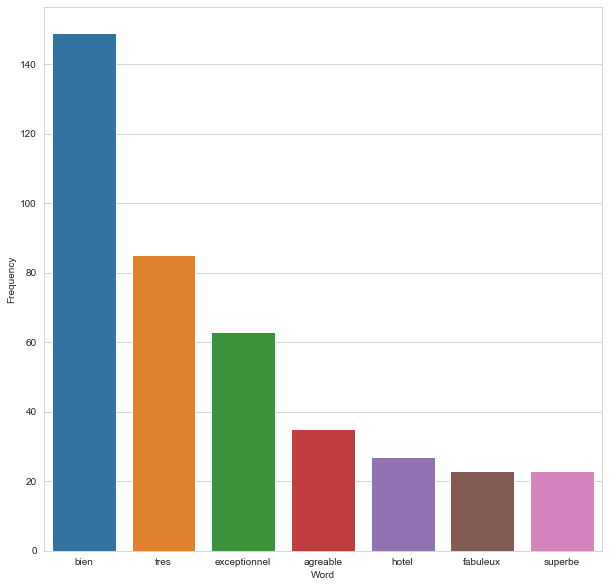

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

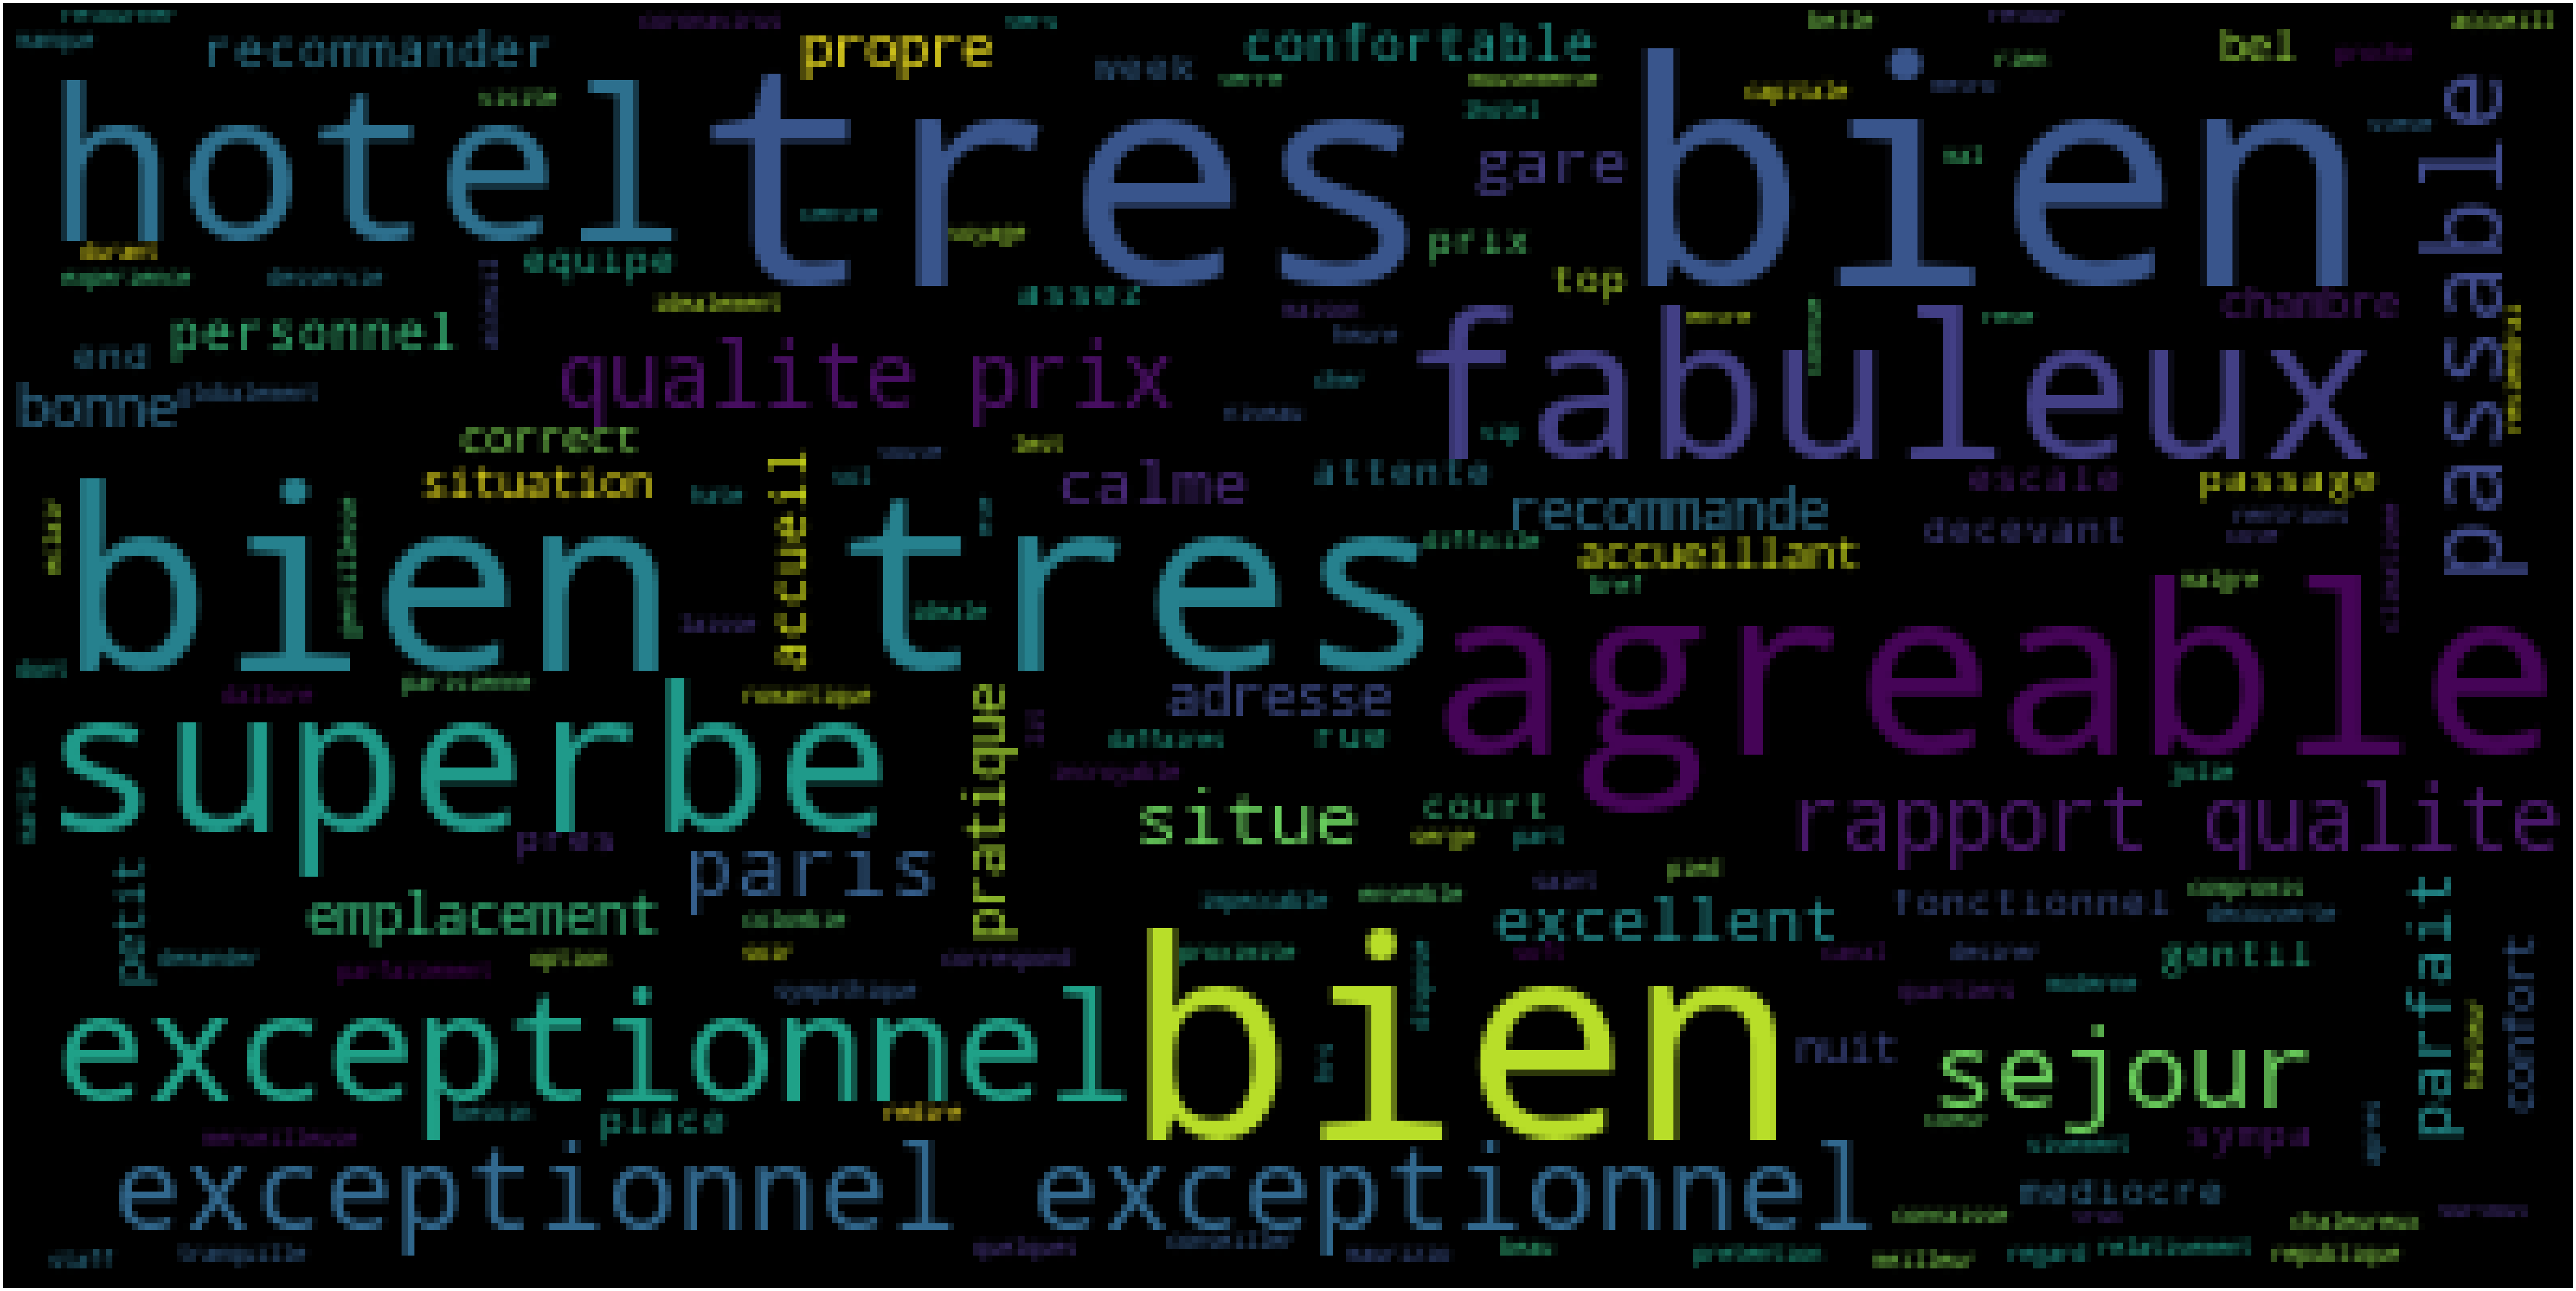

In [32]:
#nuage de mots
wc(cleaned_data_title,'black','Common Words' )

In [33]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
text = u"Quelle belle matinée"
blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [34]:
blob.sentiment

(0.8, 0.8)

In [35]:
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
bloblist_desc = list()
df_str=df['titre'].astype(str)
df_str.head(15)
for row in df_str:
    # conversion du français vers l'anglais
    text_blob_object_french = TextBlob(row)
    text_blob_en = text_blob_object_french.translate(to='en')
    print(text_blob_en)
    blob = tb(str(text_blob_en))
    print(blob.sentiment, str(text_blob_en))

HTTPError: HTTP Error 429: Too Many Requests

In [36]:
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
bloblist_desc = list()
df_str=df['titre'].astype(str)
df_str.head(15)
for row in df_str:
    # conversion du français vers l'anglais
    text_blob_object_french = TextBlob(row)
    text_blob_en = text_blob_object_french.translate(to='en')
    #print(text_blob_en)
    blob = tb(str(text_blob_en))
    #print(blob)
    #print(blob.sentiment)
    print(blob.sentiment, str(text_blob_en))

HTTPError: HTTP Error 429: Too Many Requests

In [37]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
bloblist_desc = list()

df_str=df['titre'].astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif df_polarity_desc['sentiment'] < 0:
        val = "Negative"
    else:
        val = "Neutre"
    return val

df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

0.0
0.235
0.3
0.8
0.0
0.0
1.0
0.35000000000000003
0.0
0.7
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.1
0.625
0.7
0.0
0.0
0.5
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.7
0.0
0.375
1.0
0.2
0.4
0.0
0.4
0.0
0.0
1.0
0.0
0.0
0.0
0.3
0.3325
0.0
0.0
0.7
0.0
0.0
0.4
0.0
0.0
1.0
1.0
0.2
0.7
0.0
0.0
1.0
0.2
0.37333333333333335
0.2
0.425
0.7
0.2
1.0
0.0
0.0
1.0
0.0
0.0
0.9
0.7
1.0
0.0
0.2
0.7
0.0
0.7
1.0
0.2
0.0
0.2
0.4375
0.5650000000000001
0.0
0.01
0.0
0.0
0.2
0.0
1.0
0.7
0.5
0.2
0.0
0.0
1.0
0.0
0.1
0.0
0.30000000000000004
0.38999999999999996
0.085
0.0
1.0
0.0
0.0
0.45999999999999996
1.0
0.7
0.2
1.0
0.35
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.6333333333333334
0.7
0.0
0.0
0.7
0.2
0.085
0.7
0.43333333333333335
0.2
0.0
0.7
0.0
0.7
0.0
0.05
0.8
0.0
0.7
0.7
0.235
0.2
1.0
0.7
0.05
0.7
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.3
0.7
1.0
0.0
0.2
0.2
0.0
0.53
0.2
0.0
0.7
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.0
0.2
-0.105
0.2
0.7
0.25
0.2
0.0
0.425
0.22
0.2
0.7
0.2
0.0
0.7
0.2
0.0
0.4
0.2
0.62
0.2
0.2
0.6
0.2
0.3925
0.35
0.2
-0.4
0.7


ValueError: Could not interpret input 'Sentiment_Type'

<Figure size 720x720 with 0 Axes>

In [38]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif df_polarity_desc['sentiment'] < 0:
        val = "Negative"
    else:
        val = "Neutre"
    return val

df_polarity_desc.apply(f, axis=1)

0        Neutre
1      Positive
2      Positive
3      Positive
4        Neutre
         ...   
384    Positive
385      Neutre
386    Positive
387    Positive
388    Positive
Length: 389, dtype: object

In [39]:
df_polarity_desc['polarite']=df_polarity_desc.apply(f, axis=1)

In [40]:
df_polarity_desc.head()

,sentiment,polarite
0,0.000,Neutre
1,0.235,Positive
2,0.300,Positive
3,0.800,Positive
4,0.000,Neutre


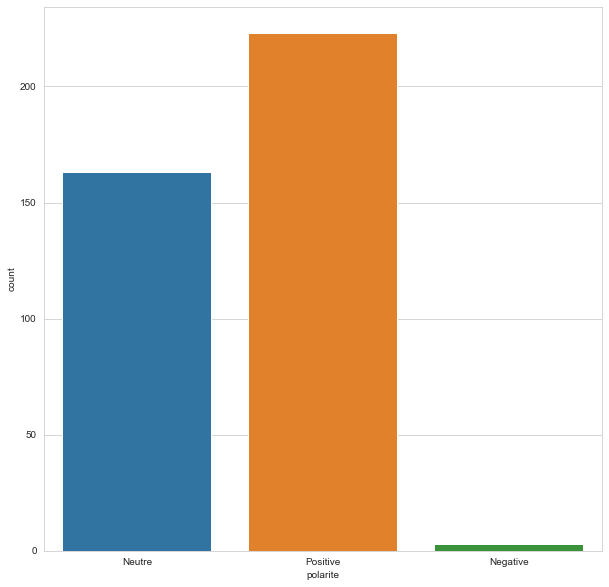

In [41]:
df_polarity_desc.head()
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="polarite", data=df_polarity_desc)

In [ ]:
df.head()

In [ ]:
df_polarity_desc.head()

In [ ]:
#from textblob_fr import PatternTagger, PatternAnalyzer
bloblist_desc = list()

df_str=df['titre'].astype(str)
for row in df_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
 
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif df_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

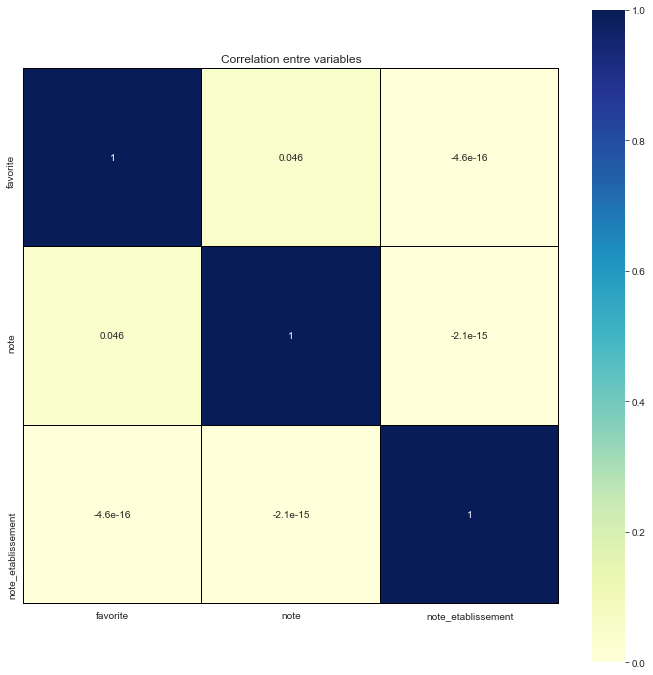

In [46]:
# affichage des corrélations entre variables
f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

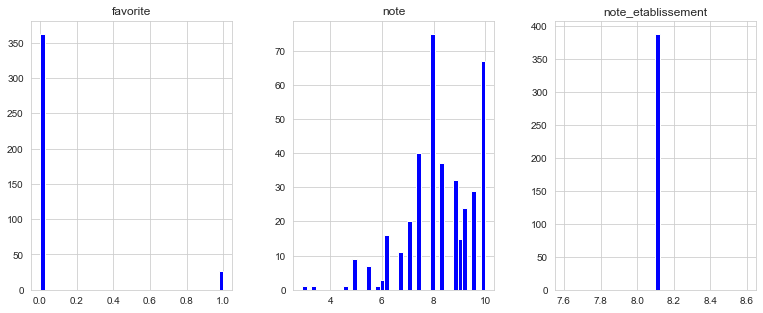

In [44]:
df.hist(figsize=(13,50),color='blue',bins=40,layout=(8,3))
plt.show()

In [ ]:
# y variable dépendante et X variables indépendantes
#X = df.iloc[:, df.columns !='polaritecomments'].values
#y = df.iloc[:, 5].values

In [47]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#print (X_train.shape,y_train.shape)
#print (X_test.shape, y_test.shape)

In [ ]:
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [48]:
#train = pd.DataFrame(X_train)

In [49]:
#train.hist(figsize=(13,50),color='blue',bins=40,layout=(8,3))
#plt.show()

In [ ]:
#param_grid = {'max_depth' : [3, 10, 15],
#    'random_state': [0, 42],
#             'n_estimators' : [10, 50]}
#grid = GridSearchCV( RandomForestClassifier(), param_grid)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

#model = grid.best_estimator_
#yfit = model.predict(X_test)

In [ ]:
#weights = (y == 0).sum() / (1.0 * (y == 1).sum())

In [51]:
#def get_score(model,X_train,X_test,y_train,y_test):
    #model.fit(X_train,y_train)
    #return model.score(X_test,y_test)

In [53]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

LR = LogisticRegression()
SVM = SVC()
DTC = DecisionTreeClassifier(max_depth = 5, random_state= 42)
RF = RandomForestClassifier(max_depth = 5, n_estimators= 10, random_state= 42)
XGBC = XGBClassifier(max_depth = 5, scale_pos_weight = weights, \
                n_jobs = 4)

logis=list()
svm=list()
arb=list()
rfl=list()
clf=list()

for index_train, index_test in kf.split(d_model):
    X_train, X_test, y_train, y_test = X[index_train], X[index_test], y[index_train], y[index_test]
    logis.append(get_score(LR, X_train, X_test, y_train, y_test))
    svm.append(get_score(SVM, X_train, X_test, y_train, y_test))
    arb.append(get_score(DTC, X_train, X_test, y_train, y_test))
    rfl.append(get_score(RF, X_train, X_test, y_train, y_test))
    clf.append(get_score(XGBC, X_train, X_test, y_train, y_test))
    
print(np.mean(logis))
print(np.mean(svm))
print(np.mean(arb))
print(np.mean(rfl))
print(np.mean(clf))

NameError: name 'LogisticRegression' is not defined

In [54]:
# y variable dépendante et X variables indépendantes
X = d_model.iloc[:, d_model.columns !='isFraud']
Y = d_model.iloc[:, 5]

X_t = pd.DataFrame(X_train)
feature_importances = pd.DataFrame(RF.feature_importances_, index = X.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

NameError: name 'd_model' is not defined

In [55]:
features = X.columns
importances=RF.feature_importances_
indices=np.argsort(importances)
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('importance du score');
plt.ylabel('variables indépendantes');
plt.title('Ordre d\'importance des variables indépendantes');
plt.show()

NameError: name 'X' is not defined

In [56]:
def MatriceConfusion (model):
    y_pred = model.predict(X_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

In [57]:
y_pred = MatriceConfusion(LR)

NameError: name 'LR' is not defined